# L4 - Reinforcement learning

**Reinforcement learning** is one of the machine learning approaches, where our agent learns by interacting with the some environment. In contrast to the supervised learning there are no labeled objects. However, agent can get rewards, making some actions. The goal of the agent is to maximize the total reward over some time period. 

This lab is mainly based on the [book](http://incompleteideas.net/book/bookdraft2018jan1.pdf). You just must read it, if you are interesting in reinforcement learning.

### 1. Multi-armed bandit problem

#### Problem statement
##### Informal
Let we have $N$ slot machines. Playing on the $i$th slot, the agent receives some random reward. The agent doesn't know probability distribution of rewards, however it needs to maximize winnings after $T$ games.

##### Formal
Let $\mathcal{A}$ be a finite set of possible actions. For each action $a \in \mathcal{A}$ agent can get some reward which is determined by the unknown probability distribution $p(r|a)$. The strategy of the agent (policy) at time $t$ is some probability distribution on the set of actions – $\pi_t(a)$.

Games' steps:
> 1. Agent has some initial policy $\pi_1(a)$
> 2. At time  $1 \leq t \leq T$:
> 3. Agent randomly chooses action $a_t \sim \pi_t(a)$
> 4. Gets some reward $r_t \sim p(r|a_t)$
> 5. And update its policy $\pi_t \rightarrow \pi_{t+1}$

Let $c_t(a)$ be how many times action $a$ was used at  moment $t$
$$c_t(a) = \sum_{i=1}^{t}[A_i = a].$$
Then agent needs to minimize its regret
$$T\cdot\mu^* - \sum_a \mu_a \mathbb{E}[c_T(a)]$$
* $\mu_a$ – expected value of reward for action $a$
* $\mu^* = \max_a \mu_a$ – expected value of reward for optimal action

So we can define regrest as following
$$T\cdot\mu^* - \mathbb{E}\big[ \sum_{t=1}^{T} R_t \big].$$

The first task was formulated in this [paper](http://projecteuclid.org/download/pdf_1/euclid.bams/1183517370).
#### Model problem
1. $|A| = 100, T = 1000$
2. $\mu_a \sim \mathcal{N}(0, 1)$
3. $p(r|a) = \mathcal{N}(r; \mu_a, 1)$

The game simulated $10^4$ times and we are interesting in plot **[step]** $\times$ **[average total reward at current step]**.

1. $Q_t(a)$ – average reward of action $a$ by moment $t$ (value of action), $\lim_{c_t(a) \rightarrow \infty} Q_t(a) =\mu_a$.
2. $Q^*(a) = \lim_{t \rightarrow \infty} Q_t(a) = \mu_a$ – value of cation $a$.
3. $\mathcal{A}_t = \arg\max_a Q_t(a)$ – set of actions that has the greatest average reward at moment $t$.

#### Greedy policy
$$\pi_t(a)= \frac{1}{|\mathcal{A}_t|}[a \in \mathcal{A}_t].$$

#### Exercises
1. Implement gready policy.
2. What is main disadvantages?
3. How do you init $\pi$? Is there any better option?
4. Check this policy on model problem.

Используя эту стратегию агент совсем не исследует своё окружение.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

A_size = 100
T = 1000
experements_n = 10000
global A_size, T, experements_n

In [2]:
class agent:
    def __init__(self, upd_pol, env):
        self.env = env
        self.step = 1
        self.count = np.zeros(A_size)
        self.policy = np.array([1/A_size for i in range(A_size)])
        self.average_reward = np.zeros(A_size)
        self.upd_policy = upd_pol
        
    def get_action(self):
        return np.random.choice(A_size, p=self.policy)
    
    def update(self, action, reward):
        self.average_reward[action] = (self.average_reward[action]*self.count[action] + reward) / (self.count[action]+1)
        self.policy = self.upd_policy(self, action, reward)
        self.count[action] += 1
        self.step += 1

class bandit:
    def __init__(self):
        self.reward_dis = np.random.normal(loc=0, scale=1, size=A_size)
        
    def turn(self, action):
        return np.random.normal(loc=self.reward_dis[action], scale=1)
        
    def game(self, upd_pol):
        total_reward = 0
        player = agent(upd_pol, self)
        reward_list = []
        for i in range(T):
            action = player.get_action()
            reward = self.turn(action)
            total_reward += reward
            player.update(action, reward)
            reward_list.append(total_reward)
            
        return np.array(reward_list)

In [3]:
def gready_upd(player, action, reward):
    ret = np.zeros(A_size)
    max_aver = player.average_reward.max()
    max_count = len(np.where(player.average_reward == max_aver)[0])
    for i in range(len(player.average_reward)):
        if player.average_reward[i] == max_aver:
            ret[i] = 1 / max_count
            
    return ret

In [4]:
def test(upd, info=False):
    result = np.zeros(T)
    for i in range(experements_n):
        env = bandit()
        scores = env.game(upd)
        result += scores
        if info and (i+1) % 100 == 0:
            print('Experiment:', i+1)
    result /= experements_n
    return result

In [5]:
def plot_all(plot_list, names):
    plt.figure(figsize=(10, 8))
    for i in range(len(plot_list)):
        plt.plot(np.arange(1, len(plot_list[i])+1), plot_list[i], label=names[i])
    plt.xlabel('Step')
    plt.ylabel('Average reward')
    plt.legend()
    plt.show()

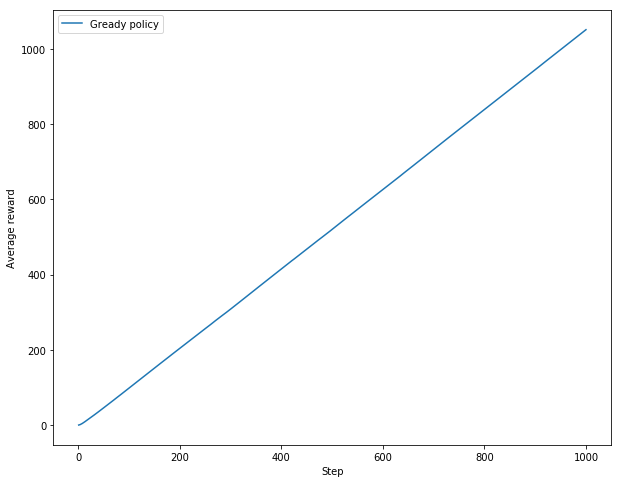

In [6]:
gready_result = test(gready_upd)
total_names = ['Gready policy']
total_results = [gready_result]
plot_all(total_results, total_names)

#### $\varepsilon$-greedy policy
The previous approach only exploits the environment. However, agent should spend some time learning probability distribtion of rewards, to maximize its reward in the long term. Thus is a question of balance **exploration** and **exploitation**.

Possible improvement:
$$\pi_t(a)=\frac{1-\varepsilon}{|\mathcal{A}_t|}[a \in A_t] + \frac{\varepsilon}{|\mathcal{A}|},\ \varepsilon \in [0, 1].$$

#### Exercises
1. Implement this policy.
2. What happens if you increase $\varepsilon$?
3. How do you change $\varepsilon$ during agent learning?
4. Check this policy on model problem, using different $\varepsilon$.

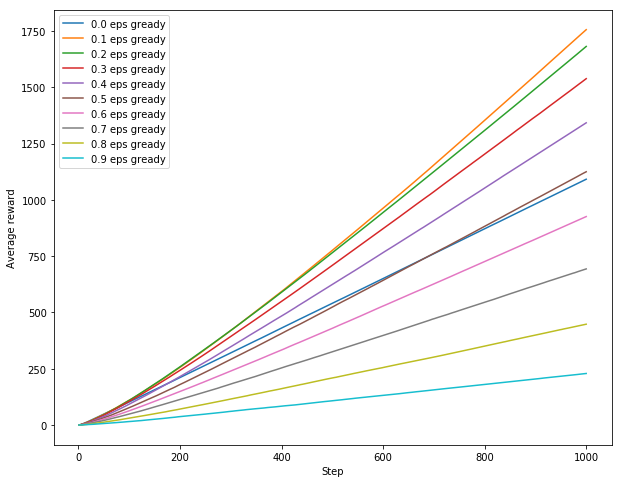

In [7]:
eps_gready = []
eps_names = []
for eps in np.arange(0.0, 1.0, 0.1): #0.12
    def eps_gready_upd(player, action, reward):
        p = np.random.rand()
        if p < eps:
            ret = np.array([1/A_size for i in range(A_size)])
        else:
            ret = np.zeros(A_size)
            max_aver = player.average_reward.max()
            max_count = len(np.where(player.average_reward == max_aver)[0])
            for i in range(len(player.average_reward)):
                if player.average_reward[i] == max_aver:
                    ret[i] = 1 / max_count    
        return ret

    eps_gready.append(test(eps_gready_upd))
    eps_names.append(str(eps)+' eps gready')

plot_all(eps_gready, eps_names)

In [8]:
total_results.append(eps_gready[1])
total_names.append('Eps gready')

#### Softmax
One more interpretation of $\varepsilon$-greedy policy

$$\pi_t(a)=\frac{\exp(\frac{1}{\varepsilon} \cdot Q_t(a))}{\sum_{b} \exp(\frac{1}{\varepsilon} \cdot Q_t(b))},\ \varepsilon >0.$$

#### Exercises
1. Implement this policy.
2. What happens if $\varepsilon \rightarrow 0$? What about $\varepsilon \rightarrow \infty$?
3. Compare softmax and $\varepsilon$-greedy policy on model problem.

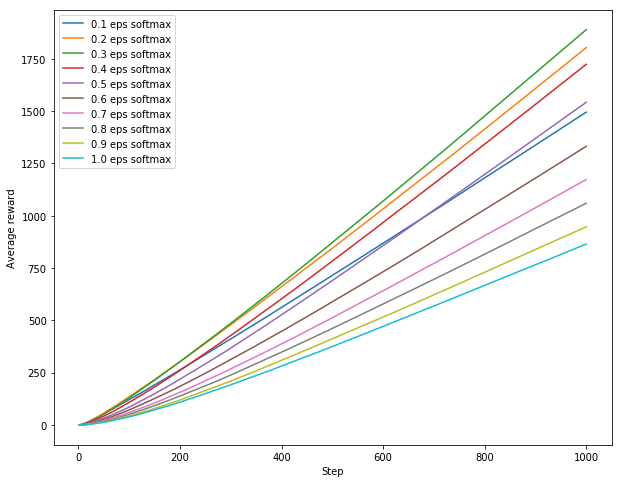

In [9]:
eps_softmax = []
softmax_names = []
for eps in np.arange(0.1, 1.1, 0.1):
    def eps_softmax_upd(player, action, reward):
        ret = np.array([np.e**((1/eps)*player.average_reward[i]) for i in range(A_size)]) 
        ret /= ret.sum()
        return ret

    eps_softmax.append(test(eps_softmax_upd))
    softmax_names.append(str(eps)+' eps softmax')

plot_all(eps_softmax, softmax_names)

In [10]:
total_results.append(eps_softmax[2])
total_names.append('Eps softmax')

#### UCB (upper confidence bound)
For each moment $t$ agent defines the most potentially profitable actions. Agent choice of $a \in A_t$ in accordance with following rule
$$\mathcal{A}_t = \arg\max Q_t(a) + \varepsilon \sqrt{\frac{2 \ln t}{c_t(a)}},\ \varepsilon \geq 0$$

The first part is well known, but the second summand is measure of how accurate agent estimates $Q_t(a)$ at this moment. The policy itself balances between exploration and exploitation. This policy can be considired as optimal in some sense, more inforamtion [here](http://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf).

#### Exercises
1. Implement policy.
2. What happens if $\varepsilon \rightarrow 0$? What about $\varepsilon \rightarrow \infty$?
3. Compare this policy with softmax and $\varepsilon$-greedy policy.

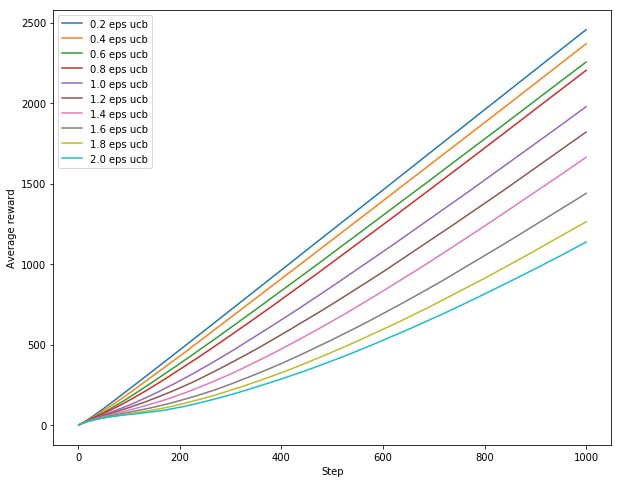

In [11]:
ucb = []
ucb_names = []
for eps in np.arange(0.2, 2.2, 0.2):
    def ucb_upd(player, action, reward):
        if player.count.min() == 0:
            for i in range(A_size):
                player.count[i] += 1
                player.average_reward[i] = player.env.turn(i)
        ret = player.average_reward.copy()
        ret += eps*np.sqrt((2*np.log(player.step))/(player.count))
        max_w = ret.max()
        for i in range(A_size):
            if ret[i] != max_w:
                ret[i] = 0
        ret /= ret.sum()
        return ret

    ucb.append(test(ucb_upd))
    ucb_names.append(str(eps)+' eps ucb')

plot_all(ucb, ucb_names)

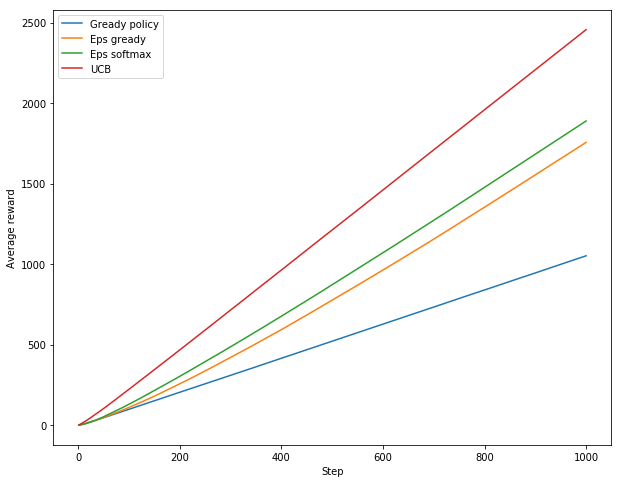

In [12]:
total_results.append(ucb[0])
total_names.append('UCB')

plot_all(total_results, total_names)

#### Gradient policy
There are also adaptive policy. They can be used, if the environment is not stationary (the distribution of rewards may slowly change). In this case, it is proposed to use the already familiar exponential smoothing
We find smoothed average reward at moment $t$ for all actions:
$$\bar{r}_{t+1} = (1-\alpha_t)\cdot\bar{r}_t(a)+\alpha_t r_{t+1} = \bar{r}_t +\alpha_t (r_{t+1}-\bar{r}_t(a)),\ \alpha_t \in [0, 1].$$

**Hint** Сonvergence condition
* $\sum^{\infty} \alpha_t = \infty$
* $\sum^{\infty} \alpha^2_t < \infty$

By the way, if $\alpha_t = \frac{1}{t}$, then $\bar{r}_{t+1}$ is just average of all $r_t$.

For each action we have some priority $p_t(a)$. After each step we make following update
$$p_{t+1}(a) = p_t(a)+\lambda(r_t-\bar{r}_t)(1-\pi_t(a)), \text{ $a$ is choosen,}$$

$$p_{t+1}(a) = p_t(a)-\lambda(r_t-\bar{r}_t)\pi_t(a), \text{ another case.}$$

So policy $\pi_{t+1}$ looks like:
$$\pi_{t+1}(a) = \frac{\exp(p_{t+1}(a))}{\sum_{b} \exp(p_{t+1}(b))}$$
More details about this method you can find in the book.

#### Exercise
1. Implement policy.
2. In conclusion, try to understand which model is better for our problem.

/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in power
/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/roman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


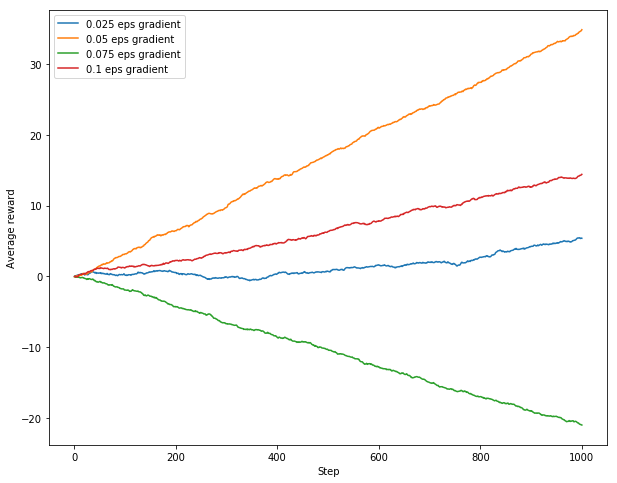

In [13]:
gradient = []
gradient_names = []
for eps in np.arange(0.025, 0.1, 0.025):
    priority = np.zeros(A_size)
    sm_aver = 0
    
    def alpha(t):
        return 1 / t
    
    def gradient_upd(player, action, reward):
        global priority, sm_aver
        sm_aver += reward
        sm_aver /= player.step
        act_prior = priority[action] + eps*(reward - sm_aver)*(1-player.policy[action])
        priority -= eps*(reward - sm_aver)*player.policy
        priority[action] = act_prior
        sm_aver *= player.step
        ret = np.e**priority
        ret /= ret.sum()
        return ret

    gradient.append(test(gradient_upd))
    gradient_names.append(str(eps)+' eps gradient')

plot_all(gradient, gradient_names)

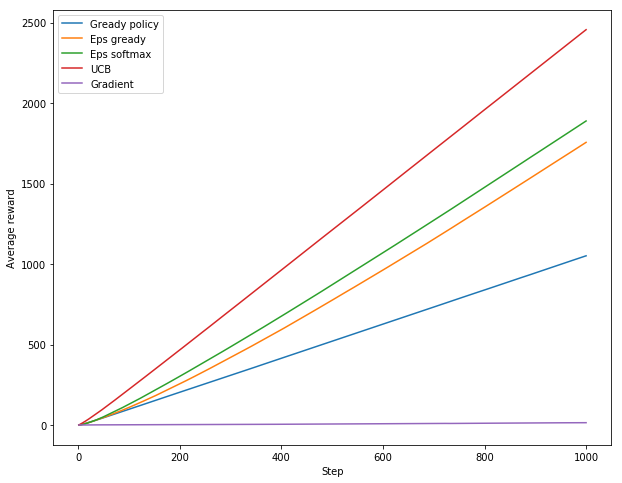

In [14]:
total_results.append(gradient[3])
total_names.append('Gradient')

plot_all(total_results, total_names)

Видно что UCB является лучшей из представленных стратегий обновления.

### 2. Markov decison process
#### Problem statement
Now agent acts in some environment with finite set of states $\mathcal{S}$. At moment $t$ agent at state $s_t$ can choose action $a_t \in \mathcal{A}_{s_t} \subset \mathcal{A}$. After agent's action, environment moves it to state $s_{t+1}$ and give reward $r_{t+1}$. Environment behaviour is defined with
$$p(s_{t+1}, r_{t+1}|s_t, a_t)  = \Pr\{ S_{t+1} = s_{t+1}, R_{t+1} =  r_{t+1} | S_t = s_t, A_t = a_t\}.$$

Agent has some policy $\pi$, which at moment $t$ defines probabilty of action $a_t \in \mathcal{A}_{s_t}$ for state $s_t$ $\pi_t(a_t|s_t) = p(a_t|s_t)$. Informally agent needs to maximize the total reward. If the decision process is finite, the problem is formalized as maximizing
$$G = \sum_{t=0}^{T} R_{t+1},$$
here $T$ – moment of time, when agent achives final state. We will consider this value as a random. If the process can last very long or infinite time than we have dealing with a discounted reward
$$ G_t = \sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1},$$
here $\gamma \in [0, 1]$ defines how deep we look into the future.

The probability that the process moves into its new state is influenced by the chosen action. Specifically, it is given by the state transition function. Thus, the next state  depends on the current state and the decision maker's action. But given state and action, it is conditionally independent of all previous states and actions, in other words, the state transitions of an MDP satisfies the Markov property.

#### Exercises
1. Give life example of Markov decision process (it may be any game, etc.).
2. Can you give an example where a decision can't be modeled with a Markov process?
3. Using $p(s_{t+1}, r_{t+1}|s_t, a_t)$, find values below (all distribution are discrete):
  * $r(s_{t}, a_{t}) = \mathbb{E}[R_{t+1}|S_t = s_t, A_t = a_t]$ – average reward for action $a_t$ in state $s_t$ 
  * $p(s_{t+1} | s_t, a_t) = \Pr\{S_{t+1} = s_{t+1} | S_t = s_t, A_t = a_t \}$ – probability to move from $s_t$ to $s_{t+1}$, making $a_t$.
  * $r(s_t, a_t, s_{t+1}) = \mathbb{E}[R_{t+1}|S_{t+1} = s_{t+1}, S_t = s_t, A_t = a_t]$ – average reward when moving from $s_t$ to $s_{t+1}$, making $a_t$.

1. Игра го или шашки являются примером Марковского процесса.
2. Шахматы не являются Марковским процессом из-за таких правил как например рокировка т. к. мы не можем по расположению фигур на доске однозначно понять двигались ли ладья и король или нет.
3. 
 * $r(s_{t}, a_{t}) = \mathbb{E}[R_{t+1}|S_t = s_t, A_t = a_t] = \sum \limits_{r \in R} r \cdot p_r = \sum \limits_{r \in R} r \cdot \sum \limits_{s \in S}p(s, r|s_t, a_t)$
 
 * $p(s_{t+1} | s_t, a_t) = \Pr\{S_{t+1} = s_{t+1} | S_t = s_t, A_t = a_t \} = \sum \limits_{r \in R}p(s_{t+1}, r|s_t, a_t)$ 
 
 * $r(s_t, a_t, s_{t+1}) = \mathbb{E}[R_{t+1}|S_{t+1} = s_{t+1}, S_t = s_t, A_t = a_t] = \sum \limits_{r \in R} r \cdot p_r = \sum \limits_{r \in R} r \cdot p(s_{t+1}, r|s_t, a_t)$

#### Main definitions 
State-value function under the strategy of $\pi$ returns for state $s$ total reward, that agent gets, starting from $s$
$$V^\pi(s) = \mathbb{E}[G_t|S_t=s] = \mathbb{E}\Big[\sum_{k=0}^{\infty} \gamma^{k+1}R_{t+k+1}|S_t=s\Big].$$

Action-value function under the strategy $\pi$ for action $a$ and state $s$ returns total reward that agent gets, starting from $s$ and making $a$
$$Q^\pi(s, a) = \mathbb{E}[G_t|S_t=s, A_t=a] = \mathbb{E}\Big[\sum_{k=0}^{\infty} \gamma^{k+1}R_{t+k+1}|S_t=s,  A_t=a\Big].$$

Thus we have following equations (the first two are Bellman equations):

$$V^{\pi}(s) = \mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s\big]$$

$$Q^{\pi}(s, a) = \mathbb{E}\big[R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) | S_t=s, A_t=a\big]$$

$$Q^{\pi}(s, a) = \mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s, A_t=a\big]$$

#### Remark
It is important to note that policy $\pi$ is fixed and doesn't change with time. Although in real practice it is not true, because our strategy is constantly updating when agent learns environment.
Policy $\pi^{*}$ is optimal, if for each state $s$ and any other policy $\pi$ it is true that $V_{\pi^{*}}(s) \geq V_{\pi}(s)$. Posibly, there are several different optimal policies, however functions $V(s)$ and $Q(s, a)$, which they defines are the same. So, we denote these functions $V^*(s)$ и $Q^*(s, a)$ as optimal.

Equations below are Bellman optimality equations (more info [here](https://en.wikipedia.org/wiki/Bellman_equation):
$$V^*(s) = \max_{a \in \mathcal{A}} \mathbb{E}\big[R_{t+1} + \gamma V^*(S_{t+1}) | S_t=s, A_t=a\big]$$
$$Q^*(s, a) = \mathbb{E}\big[R_{t+1} + \gamma \max_{b \in \mathcal{A}} Q^*(S_{t+1}, b) | S_t=s, A_t=a\big]$$

Then the following two greedy strategies are equivalent and optimal ($\mathcal{A}_t$ – set):
$$\mathcal{A}_t = \arg\max_{a \in \mathcal{A}} \mathbb{E}\big[R_{t+1} + \gamma V^*(s_{t+1}) | s_t, a \big]$$
$$\mathcal{A}_t = \arg\max_{a \in \mathcal{A}} Q^*(s_t, a)$$

#### Dynamic programming
This part is based on the fact, that $p(s',r|s,a)$ is known.

#### Iterative policy evaluation
Let agent has some fixed policy $\pi$, then for $V^{\pi}$ we have
$$V^{\pi}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) \big[r + \gamma V^{\pi}(s') \big]$$

For simplicity we assume that the distribution of rewards is discrete random variable. Otherwise, it is necessary to use operator of integration instead of sum. For each state $s$ we can can evaluate $V^{\pi}$, using iterative algorithm ($V_0$ is initialized randomly)
$$V_{n+1}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) \big[r + \gamma V_n(s') \big].$$

By the way, if $s$ is a final state, then $V(s)$ is already known and we may use this value as initialization for faster convergence. The computation stops when $V(s)$ varies negligible from iteration to iteration.

#### Remarks
1. We make assumption that $p(s',r|s,a)$ is known, but it's often not truth in practice.
2. Compution of $V_{n+1}$ can be done **in place**, it accelerates convergence, since in the process of computation we will use the values from iteration $n$ and some new values from iteration $n+1$.

#### Policy improvement theorem
Suppose there are policies $\pi$ and $\pi'$, and for each state $s$ we have
$$Q^{\pi}(s, \pi'(s)) \geq V^{\pi}(s),$$
then the following inequality holds
$$V^{\pi'}(s) \geq V^{\pi}(s).$$

The main interest of this theorem is that it allows us to improve the current policy. We know how to calculate $V^{\pi}(s)$, so

$$
Q^{\pi}(s, a) =
\mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s, A_t=a\big] =
\sum_{s',r}p(s',r|s, a)\big[ r + \gamma V^{\pi}(s') \big]
$$

In this way we can improve our policy
$$\pi'(a) = \arg\max_a Q^{\pi}(s, a).$$
The writing above means, that policy chooses action uniformly among all optimal actions. If we can't improve $V^{\pi}$, then out state-value function is optimal and satisfies the equation the Bellman equation. So, policy, which defines this policy, is also optimal.

#### Policy interation
Performing alternately calculation of $V^{\pi}$ and improving $\pi$, we can find optimal policy $\pi^*$. It should be noted that as initialization values of $V(s)$ you may use state-value function from previous iteration, it helps significantly speeds up the convergence of the algorithm.

#### Value interation
There is also interesting approach to compute $V^{*}(s)$ of optimal strategy $\pi^{*}$
$$V_{n+1}(s) = \max_a \sum_{s',r} p(s',r|s,a) \big[r + \gamma V_n(s') \big].$$

You may understand this method in the following way. On the one hand we in greedy manner update state value function during each iteration of value function evaluation. On the other hand we use Bellman equation to evaluate $V^{*}$ iteratively. It's rather practical method.

#### Exercises
1. Let you environment have 100 states. The distribution function $p(s',r|s,a)$ may be defined by your own.
2. Fix some discount value and find optimal policy.
3. What method is faster? For any state $s$, check how $V^*(s)$ varies during $\gamma$ changing.
4. Plot $\gamma \times V^*(s)$ for some 5 states.

In [15]:
class Environment:
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.paths = np.random.random((state_n, action_n, state_n))
        for i in range(state_n):
            for j in range(action_n):
                self.paths[i, j] /= self.paths[i, j].sum()
        self.reward_dis = (np.random.normal(0, 0.1, (state_n, action_n, state_n))*100)
        
class Markov_decison_process:
    def __init__(self, env, discount):
        self.state_n = env.state_n
        self.action_n = env.action_n
        self.paths = env.paths
        self.reward_dis = env.reward_dis
        self.discount = discount
        self.policy = (np.zeros((self.state_n, self.action_n)) + 1) / self.action_n
        self.V = np.random.normal(size = self.state_n)
        
    def iterative_policy_evaluation(self, eps=0.0001):
        max_iterations = 1000
        for i in range(max_iterations):
            V_prev = self.V
            for state in range(self.state_n):
                upd = (self.paths[state]*(self.reward_dis[state] + self.discount*V_prev)).sum(axis=1)
                upd *= self.policy[state]
                self.V[state] = upd.sum()
            if (np.abs(self.V - V_prev).max() < eps):
                break
                
    def policy_improvement(self):
        policy_prev = self.policy.copy()
        self.policy *= 0
        for state in range(self.state_n):
            upd = (self.paths[state]*(self.reward_dis[state] + self.discount*self.V)).sum(axis=1)
            prob = 1 / len(np.where(upd == upd.max())[0])
            for i in range(len(upd)):
                if upd[i] == upd.max():
                    self.policy[state][i] = prob
        return np.all(self.policy == policy_prev)
    
    def policy_iteration(self, eps=0.0001):
        while True:
            self.iterative_policy_evaluation(eps)
            if self.policy_improvement():
                break
                
    def value_iteration(self, eps=0.0001):
        max_iterations = 1000
        for i in range(max_iterations):
            V_prev = self.V
            for state in range(self.state_n):
                upd = (self.paths[state]*(self.reward_dis[state] + self.discount*self.V)).sum(axis=1)
                self.V[state] = upd.max()
            if (np.abs(self.V - V_prev).max() < eps):
                break
        self.policy_improvement()

In [16]:
state_n = 100
action_n = 50
discount = 0.8

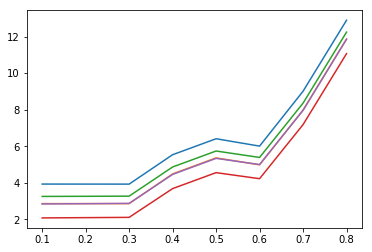

In [17]:
env = Environment(100, 50)
mdp = Markov_decison_process(env, discount)
mdp.policy_iteration()
optimal_policy = mdp.policy

gamma = [i for i in np.arange(0.1, 0.9, 0.1)]
V = [[] for i in range(5)]
for g in gamma:
    mdp = Markov_decison_process(env, g)
    mdp.policy_iteration()
    for i in range(5):
        V[i].append(mdp.V[i])
for i in range(5):
    plt.plot(gamma, V[i])

### 3. Model problem
As a model problem we choose tic-tac-toe game. One agent plays against another, so environament for each player is its opponent. The set of states $\mathcal{S}_{X}$ is all possible positions of tic-tac-toe game for Xs and the set $\mathcal{S}_{O}$ defined in the same way for Os. You need to train both agents during some series of games where they play with each other. The criterion of success – both agent don't lose human.

### 4. Temporal difference
The speech will focus on more practical methods. Let imagine that we evaluate $V^{\pi}(s)$ for our policy $\pi$. Our agent visited state $s_t$ and we know total reward $G_t$. When agent visites the state $s_t$, we can improve estimation of $V^{\pi}$ using exponential smoothing
$$V^{\pi}_{n+1}(s_t) = V_{n}^{\pi}(s_t) + \alpha \big(G_t - V_{n}^{\pi}(s_t)\big).$$

However, you can make some trick and rewrite $G_t$
$$V_{n+1}^{\pi}(s_t) = V_{n}^{\pi}(s_t) + \alpha \big(R_t + \gamma V^{\pi}(S_{t+1}) - V_{n}^{\pi}(s_t)\big),$$
so we can update $V^{\pi}(s_t)$ after each visiting $s_t$. Similarly, we can compute
$$Q_{n+1}(s_t, a_t) = Q_{n}(s_t, a_t) + \alpha \big(R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) - Q_{n}^{\pi}(s_t, a_t)\big).$$

#### SARSA (State-Action-Reward-State-Action)
So, we want to find optimal policy $\pi^{*}$. Let's suppose we have some initial approximation $Q(s, a)$. We use нее $\varepsilon$-greedy policy $\mathcal{A}_s = \arg\max_{a \in \mathcal{A}} Q(s, a)$. 

$$\pi(a|s)=\frac{1-\varepsilon}{|\mathcal{A}_s|}[a \in \mathcal{A}_s] + \frac{\varepsilon}{|\mathcal{A}|},\ \varepsilon \in [0, 1].$$

In accordance with policy $\pi$ we choose $a_t$ and get reward $R_{t+1}$, after that environment move agent to state $S_{t+1}$. Agent one more time choose action $A_{t+1} \sim \pi(a|S_{t+1})$ and doesn't act in the environemnt, but only update $Q$ function
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) - Q^{\pi}(s_t, a_t)\big).$$

Also, there is more variation of this idea, that uses expected Q-value.
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma \sum_b \pi(b|S_{t+1}) Q^{\pi}(S_{t+1}, b) - Q^{\pi}(s_t, a_t)\big).$$
So we use $\varepsilon$-greedy approach to improve our policy and evaluate.

####  Q-learning
The idea of this method is rather similar, but we also greedy update action-value function $Q$ 
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma \max_{b} Q(S_{t+1}, b) - Q(s_t, a_t)\big).$$ For choosing actions during learning agent can use any policy, e.g. $\varepsilon$-greedy or softmax policy.

#### Exercises
1. Implement both algorithm for our model problem.
2. Which one converges faster? How can you estimate it?
3. Compare how action-value function $Q(s_t, a_t)$ differs for these two methods.
4. Try to play with your agents...
5. Use intentionally losing strategy for Os. What happened?
6. Try to beat the agent for Xs.

In [18]:
state_n = 3**9
action_n = 9

board = "123456789"
state_num = 0
state_dict = dict()
def init_state_dict(num=0):
    global state_num, state_dict, board
    if num == 8:
        state_dict[board] = state_num
        state_dict[state_num] = board
        state_num += 1
    else:
        init_state_dict(num+1)
        
    board = board[:num]+'O'+(board[num+1:] if num != 8 else '') 
    if num == 8:
        state_dict[board] = state_num
        state_dict[state_num] = board
        state_num += 1
    else:
        init_state_dict(num+1)
        
    board = board[:num]+'X'+(board[num+1:] if num != 8 else '') 
    if num == 8:
        state_dict[board] = state_num
        state_dict[state_num] = board
        state_num += 1
    else:
        init_state_dict(num+1)
        
    board = board[:num]+str(num+1)+(board[num+1:] if num != 8 else '') 
        
init_state_dict()

In [19]:
class Agent:
    def __init__(self, state_n, action_n, update):
        self.policy = np.zeros((state_n, action_n)) + (1/action_n)
        self.Q = np.zeros((state_n, action_n))
        self.state = 0
        self.upd = update
        
    def get_action(self):
        return np.random.choice(9, p=self.policy[self.state])

alpha = 0.3
gamma = 0.9
def SARSA(player, state, action, reward, new_state):
    global alpha, gamma
    player.state = new_state
    A = player.get_action()
    player.Q[state, action] += alpha*(reward + gamma*player.Q[new_state, A] - player.Q[state, action])
    max_Q = player.Q[state].max()
    count = 0
    for i in range(len(player.Q[state])):
        if player.Q[state][i] != max_Q:
            player.policy[state][i] = 0
        else:
            player.policy[state][i] = 1
            count += 1
    player.policy[state] /= count
    return player

class TicTacToe:
    def __init__(self):
        self.board = "123456789"
        self.counter = 0
        
    def draw_board(self):
        board = self.board
        print("-------------")
        for i in range(3):
            print("|", board[0+i*3], "|", board[1+i*3], "|", board[2+i*3], "|")
            print("-------------")
            
    def check_win(self):
        board = self.board
        win_coord = ((0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6))
        for each in win_coord:
            if board[each[0]] == board[each[1]] == board[each[2]]:
                return True
        return False
            
    def turn(self, pos):
        board = self.board
        if (str(board[pos]) not in "XO"):
            if self.counter % 2 == 0:
                symb = 'X'
            else:
                symb = 'O'
            self.counter += 1
            self.board = board[:pos]+symb+(board[pos+1:] if pos != 8 else '')
            return True
        else:
            return False
        
    def play_game(self, first, second, info=False):
        global state_dict
        first.state = state_dict[self.board]
        second.state = state_dict[self.board]
        end = False
        f_a = 0
        f_r = 0
        s_a = 0
        s_r = 0
        while end == False:
            if self.counter % 2 == 0:
                #if self.counter != 0:
                    #first = first.upd(first, first.state, f_a, f_r, state_dict[self.board])
                
                made_turn = False
                while made_turn == False:
                    action = first.get_action()
                    made_turn = self.turn(action)
                    if (made_turn == False):
                        first = first.upd(first, first.state, action, -2, first.state)
                f_a = action
                f_r = 0
                
                end = self.check_win()
                if end:
                    first = first.upd(first, first.state, action, 20, state_dict[self.board])
                    second = second.upd(second, second.state, s_a, -20, state_dict[self.board])
                elif self.counter == 9:
                    end = True
                    first = first.upd(first, first.state, action, 0, state_dict[self.board])
                    second = second.upd(second, second.state, s_a, 0, state_dict[self.board])
            else:
                #if self.counter != 1:
                    #second = second.upd(second, second.state, s_a, s_r, state_dict[self.board])
                
                made_turn = False
                while made_turn == False:
                    action = second.get_action()
                    made_turn = self.turn(action)
                    if (made_turn == False):
                        second = second.upd(second, second.state, action, -2, second.state)
                s_a = action
                s_r = 0
                
                end = self.check_win()
                if end:
                    second = second.upd(second, second.state, action, 20, state_dict[self.board])
                    first = first.upd(first, first.state, f_a, -20, state_dict[self.board])
                elif self.counter == 9:
                    end = True
                    first = first.upd(first, first.state, f_a, 0, state_dict[self.board])
                    second = second.upd(second, second.state, action, 0, state_dict[self.board])
            
            if info:
                self.draw_board()
                
        return first, second

In [22]:
learning_steps = 1
first = Agent(state_n, action_n, SARSA)
second = Agent(state_n, action_n, SARSA)
for i in range(learning_steps):
    env = TicTacToe()
    first, second = env.play_game(first, second)

In [23]:
env = TicTacToe()
first, second = env.play_game(first, second, True)

-------------
| 1 | 2 | 3 |
-------------
| 4 | X | 6 |
-------------
| 7 | 8 | 9 |
-------------
-------------
| 1 | 2 | 3 |
-------------
| 4 | X | 6 |
-------------
| 7 | 8 | O |
-------------
-------------
| 1 | 2 | 3 |
-------------
| 4 | X | X |
-------------
| 7 | 8 | O |
-------------
-------------
| 1 | 2 | 3 |
-------------
| 4 | X | X |
-------------
| 7 | O | O |
-------------
-------------
| 1 | 2 | 3 |
-------------
| 4 | X | X |
-------------
| X | O | O |
-------------
-------------
| 1 | 2 | O |
-------------
| 4 | X | X |
-------------
| X | O | O |
-------------
-------------
| 1 | 2 | O |
-------------
| X | X | X |
-------------
| X | O | O |
-------------


In [ ]:
env = TicTacToe()
win = False
counter = 0
while not win:
    env.draw_board()
    if counter % 2 == 0:
        turn = int(input()) - 1
        env.turn(turn)
        second.state = state_dict[env.board]
    else:
        made_turn = False
        while made_turn == False:
            turn = second.get_action()
            made_turn = env.turn(turn)
    counter += 1